In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Generating Toy 2D Dataset.

In [2]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 170

X, y = make_blobs(n_samples=300,
                  cluster_std=[0.5, 0.5, 0.5],
                  random_state=random_state)

X = X[y==0,:]
y = y[y==0]
# # Scale data to have mean 0 and variance 1 
# # which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [3]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

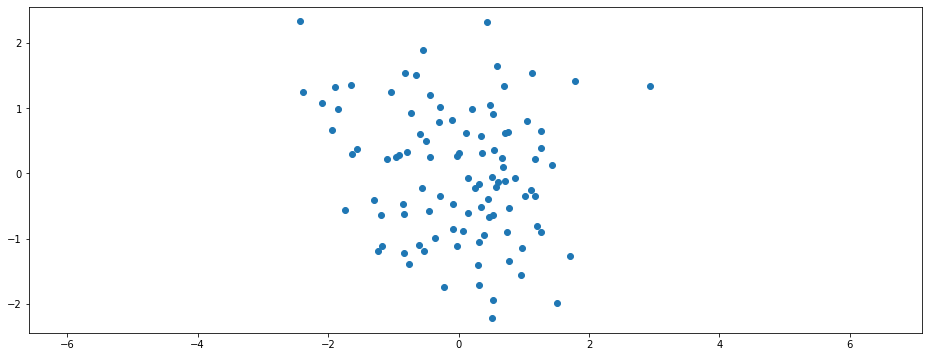

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o')

ax1.axis('equal');

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [5]:
def log_gaussian(x, mean=0):
    """
    Returns the density of x under the supplied gaussian. Defaults to
    standard gaussian N(0, I)
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :return: (*) elementwise log density
    """
    
    log_norm_constant = -0.5 * np.log(2 * np.pi)
    
    var =  torch.tensor(0.1)
    logvar = torch.log(var).reshape(1,1).to(device)
    
    A = (x - mean) ** 2
    log_p = -0.5 * (logvar + A / logvar.exp())
    log_p = log_p + log_norm_constant
#     import pdb; pdb.set_trace()
    return log_p.sum(dim=-1)



def ln_prior(Θ, σ_w=1):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w


def log_likelihood_single(μ, X, log=True):
    """
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?

    """
    
    n, d = X.shape
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], 
        μ.reshape(1, d)[:, None, :], 
    )

    return log_likelihoods.sum()


def log_likelihood(Θ, X, y=None):
    """
    batching the above (hopefully its right)
    """

    loss_ = lambda μ: log_likelihood_single(μ, X)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(Θ)

In [6]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim =  2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [7]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              ln_prior, log_likelihood, γ=1.0, device=device)

C:\Users\vargf\anaconda3\lib\site-packages\torch\_vmap_internals.py:252: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk.
  warnings.warn(
<ipython-input-5-bd9d1ba955c7>:47: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


tensor(1546.1788, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
γ = 1.0
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.01, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300

train = True
if train:
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                loss = relative_entropy_control_cost(
                    sde, Θ_0.float(),
                    X_train.float(), y_train.float(),
                    ln_prior, log_likelihood, γ=γ
                )
                optimizer.zero_grad()
                loss.backward()
                return loss

            optimizer.step(closure)
            losses.append(closure().item())
        else:
            loss = relative_entropy_control_cost(
                sde, Θ_0,
                X_train, y_train,
                ln_prior, log_likelihood, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            losses.append(loss.item())

20


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\vargf\anaconda3\lib\site-packages\torch\_vmap_internals.py:252: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk.
  warnings.warn(
<ipython-input-5-bd9d1ba955c7>:47: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


In [20]:
losses

[1451.687744140625,
 1518.5587158203125,
 1454.130615234375,
 1447.2540283203125,
 1291.2786865234375,
 1316.039306640625,
 1184.6658935546875,
 1233.3717041015625,
 1317.087158203125,
 1158.0584716796875,
 1094.017333984375,
 1094.5360107421875,
 1084.8631591796875,
 1022.4356079101562,
 1071.853759765625,
 1036.6337890625,
 981.9197998046875,
 986.9926147460938,
 970.450439453125,
 934.8773193359375,
 925.0805053710938,
 907.3358154296875,
 918.404052734375,
 907.4785766601562,
 901.797119140625,
 931.2405395507812,
 895.2091064453125,
 883.7435913085938,
 897.390625,
 884.6437377929688,
 893.3555297851562,
 865.6217651367188,
 904.397705078125,
 882.1803588867188,
 914.0098266601562,
 901.625,
 894.4642944335938,
 898.7965698242188,
 887.6434936523438,
 905.745849609375,
 878.3790283203125,
 899.3026123046875,
 887.8787841796875,
 912.1152954101562,
 894.7665405273438,
 890.3003540039062,
 912.908203125,
 917.9296875,
 900.7048950195312,
 892.1951904296875,
 887.3540649414062,
 870.

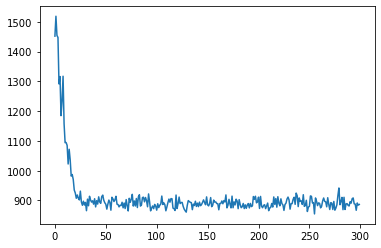

In [21]:
plt.plot(losses[:])

In [22]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([20, 50, 2])

In [23]:
torch.eye(3,2)

tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])

In [24]:
# Mannualy doing one step of Euler

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

In [25]:
Θ_1 = Θ_1.reshape(50,2)

(array([ 1.,  0.,  2.,  1., 10.,  6., 11., 11.,  5.,  3.]),
 array([-0.75416076, -0.62325865, -0.49235648, -0.36145437, -0.23055223,
        -0.09965008,  0.03125205,  0.16215418,  0.2930563 ,  0.42395845,
         0.5548606 ], dtype=float32),
 <a list of 10 Patch objects>)

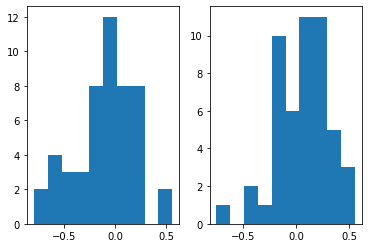

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,1].flatten().cpu().detach().numpy())

In [27]:

# Manually doing 2 steps of euler 
Θ_2 = sde.f(0, 
        sde.f(0, Θ_0) * Δt + torch.normal(0,math.sqrt(Δt), (Θ_0.shape[0], Θ_0.shape[1]) ).to(device)
    ) * Δt +  torch.normal(0,math.sqrt(Δt), (Θ_0.shape[0], Θ_0.shape[1]) ).to(device)

In [28]:
Θ_2

tensor([[-0.0966,  0.1767],
        [ 0.0321, -0.0365],
        [-0.1502, -0.3579],
        [-0.2261, -0.1561],
        [-0.4054, -0.5228],
        [-0.0458, -0.0394],
        [-0.1069,  0.0584],
        [-0.2941,  0.1297],
        [-0.0049,  0.0908],
        [-0.0542,  0.1678],
        [ 0.3236, -0.0216],
        [-0.0798,  0.6549],
        [-0.2652,  0.3210],
        [ 0.3513, -0.0988],
        [-0.0220,  0.1065],
        [ 0.3536, -0.0596],
        [-0.1342, -0.1040],
        [ 0.1000, -0.1490],
        [-0.2025, -0.1363],
        [-0.2584,  0.1880],
        [ 0.0523, -0.4530],
        [ 0.3523,  0.0691],
        [ 0.0939,  0.1024],
        [ 0.4845, -0.0576],
        [ 0.2731, -0.3017],
        [-0.0184, -0.0646],
        [-0.3032, -0.3065],
        [ 0.2559,  0.3414],
        [ 0.0284, -0.0778],
        [ 0.2468,  0.0886],
        [ 0.3418,  0.2607],
        [-0.2585,  0.1147],
        [ 0.0282,  0.3719],
        [ 0.0214,  0.1145],
        [-0.0436,  0.2373],
        [ 0.0860, -0

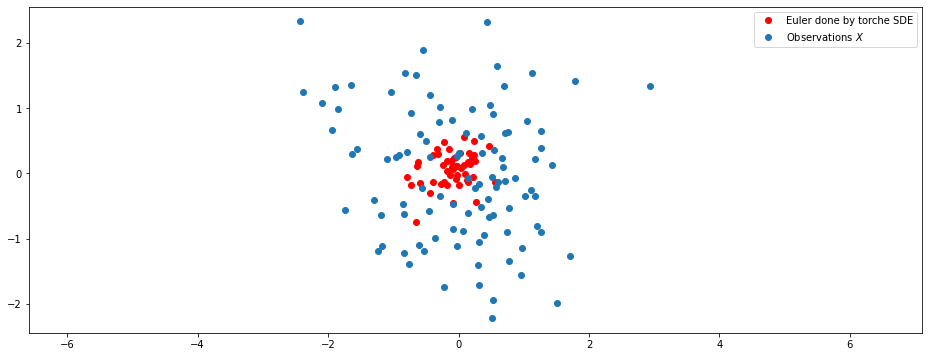

In [30]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)

Θ_plot2 = Θ_2.cpu().detach() 



ax_1.plot(Θ_plot[:, 0], Θ_plot[:, 1], 
         linestyle='none', 
         marker='o', color="red", label="Euler done by torche SDE")

# ax_1.plot(Θ_plot2[:, 0], Θ_plot2[:, 1], 
#          linestyle='none', 
#          marker='o', color="blue", label="Euler done manually")

ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');

In [19]:
Θ_plot[:, 0]-Θ_plot[:, 1]

tensor([ 0.1793,  0.1312,  0.0910,  0.2549,  0.1410,  0.0585,  0.1621,  0.1637,
         0.2204,  0.0843,  0.0656,  0.0881,  0.1349,  0.1894,  0.1220,  0.2094,
         0.2215,  0.1651,  0.0495,  0.1466,  0.1212,  0.0617,  0.1152,  0.1255,
         0.0891,  0.1635,  0.1823,  0.2343,  0.1153,  0.1324,  0.1912,  0.1300,
         0.1652,  0.2043,  0.2035,  0.3616,  0.2387,  0.0995,  0.2329,  0.1757,
         0.1981,  0.1266,  0.1408, -0.0010,  0.2378,  0.2390,  0.0642,  0.2355,
         0.1346,  0.1499])